Author: Nicolas Dumoulin

In [5]:
library(EasyABC)
library(parallel)
library(lhs)
library(mnormt)

Initializing data with numbers of individuals per age class for two years (ages_source and ages_target) and the delta of years between these two sets.

In [6]:
# MSA 2008
ages_source = c(5, 47, 194, 529, 1056, 1760, 2477, 3184, 4013, 4617, 5210, 5495, 5981, 6354, 6949, 7646, 8706, 9973, 10766, 11644, 12479, 13180, 13736, 14781, 15885, 16682, 17803, 17706, 17987, 18386, 18158, 17949, 17533, 18011, 17308, 17259, 17538, 18032, 18606, 17364, 16668, 15279, 13731, 7604, 5294, 3282, 2669, 2286, 1614, 1236, 1007, 1074, 978, 829, 789, 655, 697, 591, 496, 471, 403, 348, 323, 269, 248, 240, 220, 171, 178, 201, 248, 130, 58, 63, 43, 42, 55, 42, 30, 30, 9, 10, 15)
# MSA 2018
ages_target = c(1, 76, 268, 579, 1079, 1493, 1973, 2432, 3059, 3592, 4236, 4717, 5440, 5904, 6419, 6945, 7574, 7847, 8414, 8704, 8992, 8782, 8821, 9069, 9236, 9741, 10569, 11458, 12058, 12623, 12927, 13351, 13637, 14446, 15461, 16145, 17113, 17017, 17163, 17660, 17350, 17190, 16147, 12294, 10037, 6746, 5509, 4670, 3720, 2830, 2401, 2181, 1856, 1584, 1209, 790, 665, 595, 496, 390, 333, 346, 303, 246, 238, 205, 201, 175, 146, 125, 92, 82, 75, 55, 50, 36, 36, 26, 25, 18, 13, 10, 11)
D=10 # Years delta between the two sets

# Model definition
Here we define our model that computes the new numbers of individuals per age class at a year from the data from the precedent year.

We use a beta distribution for modeling the installation of new individuals and a linear factor for the retirement.

Let be:

- $N_{i}(y)$ the number of individual for the class i for the year y
- $A$ the amplitude of the beta distribution
- $drop$ the coefficient for rescaling the shape of the beta distribution
- $\alpha$ and $\beta$ the shape parameters of the beta distribution
- $R_{t}$ the retirement threshold, ie the age when the retirement function starts
- $R_{f}$ the retirement factor

We define the shifted number of individuals for the ageclass $i$ and the year $y$ $N_{i}^{*}(y)$, and the number of individuals for the ageclass $i$ and the year $y+1$ $N_{i}(y+1)$

$$
N_{i}^{*}(y) = \left\{\begin{array}{lr}
    0, & \text{for } i\leq 0\\
    N_{i-D}(y), & \text{for } i\gt 0\\
    \end{array}\right\}
$$

$$
N_{i}(y+1) = \left\{\begin{array}{lr}
    N_{i}^{*}(y) * (1 + A * dbeta(\frac{i}{drop},\alpha,\beta)), & \text{for } i\lt R_{t}\\
    N_{i}^{*}(y) * (1 + A * dbeta(\frac{i}{drop},\alpha,\beta) - R_{f}), & \text{for } i\geq R_{t}\\
\end{array}\right\}
$$

From the [binomial theorem](https://en.wikipedia.org/wiki/Binomial_theorem), we can develop for D years:

$$
N_{i}(y+D) = \left\{\begin{array}{lr}
    N_{i}^{*}(y) * \sum_{k=0}^{D} \tbinom{D}{k} A * dbeta(\frac{i}{drop},\alpha,\beta)^{k}, & \text{for } i\lt R_{t}\\
    N_{i}^{*}(y) * \sum_{k=0}^{D} \tbinom{D}{k} \sum_{j=0}^{k} \tbinom{k}{j} A * dbeta(\frac{i}{drop},\alpha,\beta))^{k-j}+ (-R_{t})^{j}, & \text{for } i\geq R_{t}\\
\end{array}\right\}
$$


## Beta parametrisation

As the $\alpha$ and $\beta$ parameters of the beta distribution is correlated, we use the parametrisation with the mean $\mu$ and the addition of both shape parameters $v = \alpha + \beta$ (Kruschke, John K. (2011). Doing Bayesian data analysis: A tutorial with R and BUGS. p. 83: Academic Press / Elsevier. ISBN 978-0123814852). We use the relation:

$$
\left\{\begin{array}{lr}
\alpha = \mu * v\\
\beta = (1 - \mu) * v
\end{array}\right\}
$$

# Calibrating only installation

In [7]:
last_age_for_installation = 44
installation_yearly = function(ages, x) {
  # computation of the new age at index considering parameters "x"
  age_process2 = function(index) {
    set.seed(x[1])
    # installation
    amplitude = x[2]
    drop_x=x[3]
    alpha = x[4]*x[5]
    beta = (1 - x[4])*x[5]
    new_ages[index] + amplitude*dbeta(index/drop_x, alpha, beta)
  }
  new_ages = c(0, ages[1:(length(ages)-1)])
  # Compute all the new ages
  unlist(lapply(seq_along(new_ages), age_process2))
  # 'unlist' is required because EasyABC requires a vector as output instead of a list
}
installation = function(x) {
    ages = ages_source
    for (i in seq(1,D)) {
        ages = installation_yearly(ages, x)
    }
    ages[1:last_age_for_installation]
}

In [8]:
nb_simul = 10000
p_acc_min=0.4
prior_unif = list(c("unif",100,400), c("unif",10,40), c("unif",0,1), c("unif",3,50))
ABC_Lenormand <- ABC_sequential(method="Lenormand", model=installation, prior=prior_unif, nb_simul=nb_simul,
                        summary_stat_target=ages_target[1:last_age_for_installation], p_acc_min=p_acc_min,use_seed=TRUE, progress_bar=TRUE)

[1] "    ------ Lenormand et al. (2012)'s algorithm ------"
[1] "step 1 completed"
  |==================================================| 100% Time elapsed: 00:00:45 Estimated time remaining: 00:00:00
[1] "step 2 completed - p_acc = 0.6944"
  |==================================================| 100% Time elapsed: 00:00:40 Estimated time remaining: 00:00:00
[1] "step 3 completed - p_acc = 0.5996"
  |==================================================| 100% Time elapsed: 00:00:40 Estimated time remaining: 00:00:00
[1] "step 4 completed - p_acc = 0.5338"
  |==================================================| 100% Time elapsed: 00:00:39 Estimated time remaining: 00:00:00
[1] "step 5 completed - p_acc = 0.488"
  |==================================================| 100% Time elapsed: 00:00:39 Estimated time remaining: 00:00:00
[1] "step 6 completed - p_acc = 0.4662"
  |==================================================| 100% Time elapsed: 00:00:36 Estimated time remaining: 00:00:00
[1] "step 

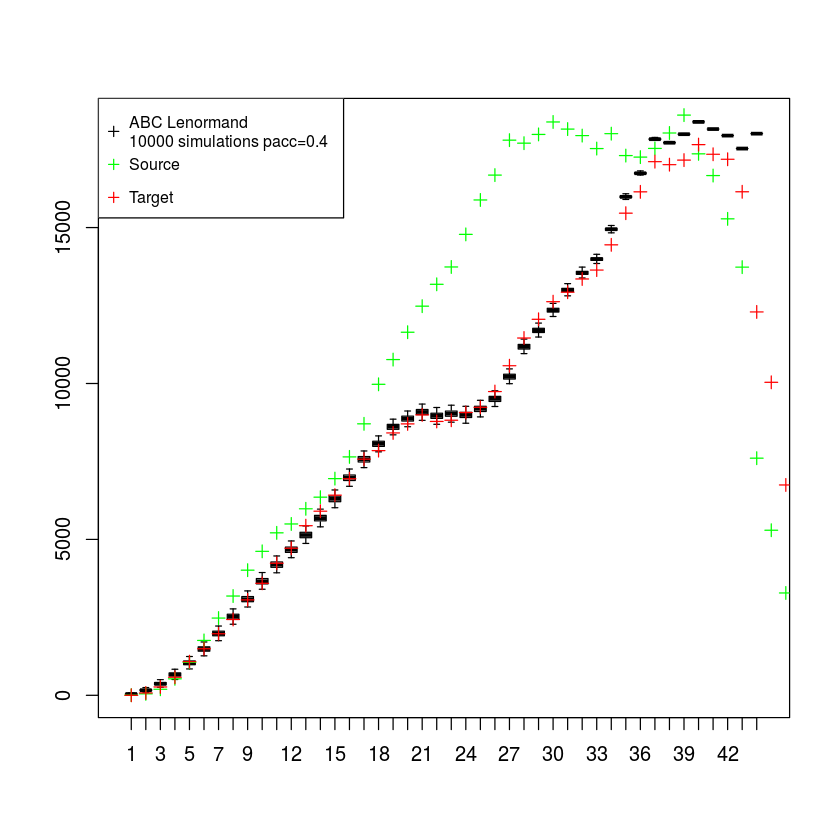

In [9]:
simulated = ABC_Lenormand$stats
boxplot(simulated,outpch=NA)
points(ages_source,pch=3,col="green")
points(ages_target,pch=3,col="red")
legend("topleft", legend=c(paste("ABC Lenormand \n",format(nb_simul)," simulations pacc=",format(p_acc_min),sep=""),"Source","Target"),
       col=c("black","green","red"),cex=.8,pch=3)

The data simulated (boxplot) fits the target data, so we retain this model.

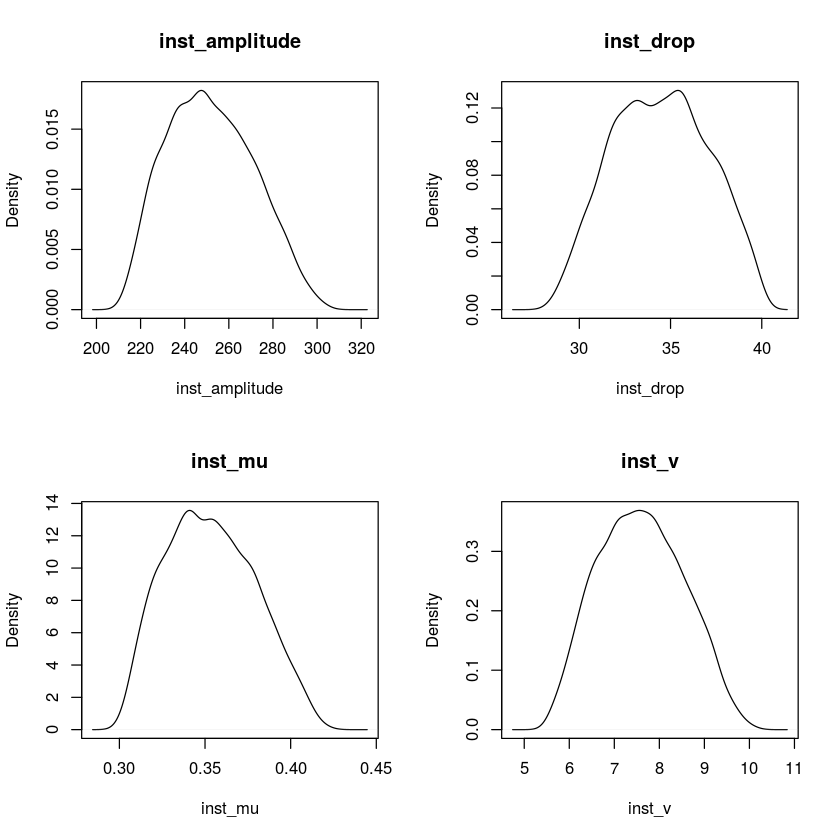

In [10]:
paramsNames = c("inst_amplitude","inst_drop","inst_mu","inst_v")
par(mfrow=c(2,2))
for (c in 1:ncol(ABC_Lenormand$param)) { 
plot(density(ABC_Lenormand$param[,c],weights = ABC_Lenormand$weights),xlab=paramsNames[c],main=paramsNames[c])
}

# Running ABC with installation and retirement

In [11]:
simulator_yearly = function(ages, x) {
  # computation of the new age at index considering parameters "x"
  age_process = function(index) {
    set.seed(x[1])
    # installation
    amplitude = x[2]
    drop_x=x[3]
    alpha = x[4]*x[5]
    beta = (1 - x[4])*x[5]
    # retirement
    retirement_threshold = x[6]
    retirement_factor = x[7]
    if (index < retirement_threshold) retirement_factor = 0
    new_ages[index] + amplitude*dbeta(index/drop_x, alpha, beta) - new_ages[index]*retirement_factor
  }
  new_ages = c(0, ages[1:(length(ages)-1)])
  # Compute all the new ages
  unlist(lapply(seq_along(new_ages), age_process))
  # 'unlist' is required because EasyABC requires a vector as output instead of a list
}
simulator = function(x) {
    ages = ages_source
    for (i in seq(1,D)) {
        ages = simulator_yearly(ages, x)
    }
    ages
}

In [12]:
nb_simul = 5000
p_acc_min=0.4
prior_unif = list(c("unif",200,400), c("unif",25,40), c("unif",0.3,.45), c("unif",4,10), c("unif",40,55), c("unif",0,0.3))
ABC_Lenormand <- ABC_sequential(method="Lenormand", model=simulator, prior=prior_unif, nb_simul=nb_simul, summary_stat_target=ages_target, p_acc_min=p_acc_min,use_seed=TRUE, progress_bar=TRUE)

[1] "    ------ Lenormand et al. (2012)'s algorithm ------"
[1] "step 1 completed"
  |==================================================| 100% Time elapsed: 00:00:25 Estimated time remaining: 00:00:00
[1] "step 2 completed - p_acc = 0.6876"
  |==================================================| 100% Time elapsed: 00:00:22 Estimated time remaining: 00:00:00
[1] "step 3 completed - p_acc = 0.55"
  |==================================================| 100% Time elapsed: 00:00:21 Estimated time remaining: 00:00:00
[1] "step 4 completed - p_acc = 0.514"
  |==================================================| 100% Time elapsed: 00:00:20 Estimated time remaining: 00:00:00
[1] "step 5 completed - p_acc = 0.4676"
  |==================================================| 100% Time elapsed: 00:00:19 Estimated time remaining: 00:00:00
[1] "step 6 completed - p_acc = 0.4384"
  |==================================================| 100% Time elapsed: 00:00:19 Estimated time remaining: 00:00:00
[1] "step 7 

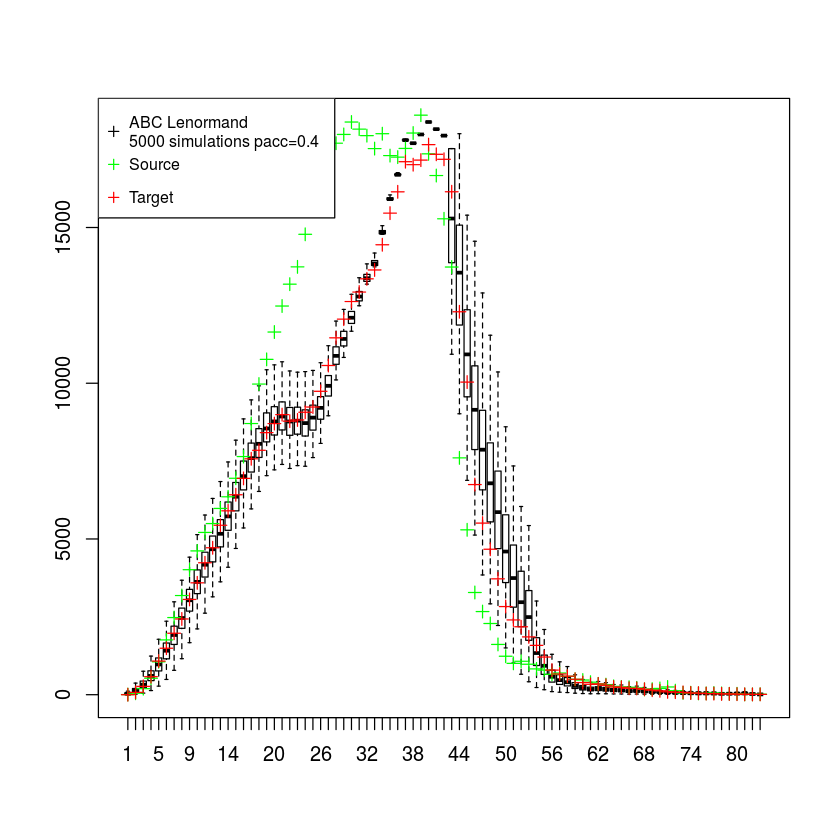

In [13]:
simulated = ABC_Lenormand$stats
boxplot(simulated,outpch=NA)
points(ages_source,pch=3,col="green")
points(ages_target,pch=3,col="red")
legend("topleft", legend=c(paste("ABC Lenormand \n",format(nb_simul)," simulations pacc=",format(p_acc_min),sep=""),"Source","Target"),
       col=c("black","green","red"),cex=.8,pch=3)

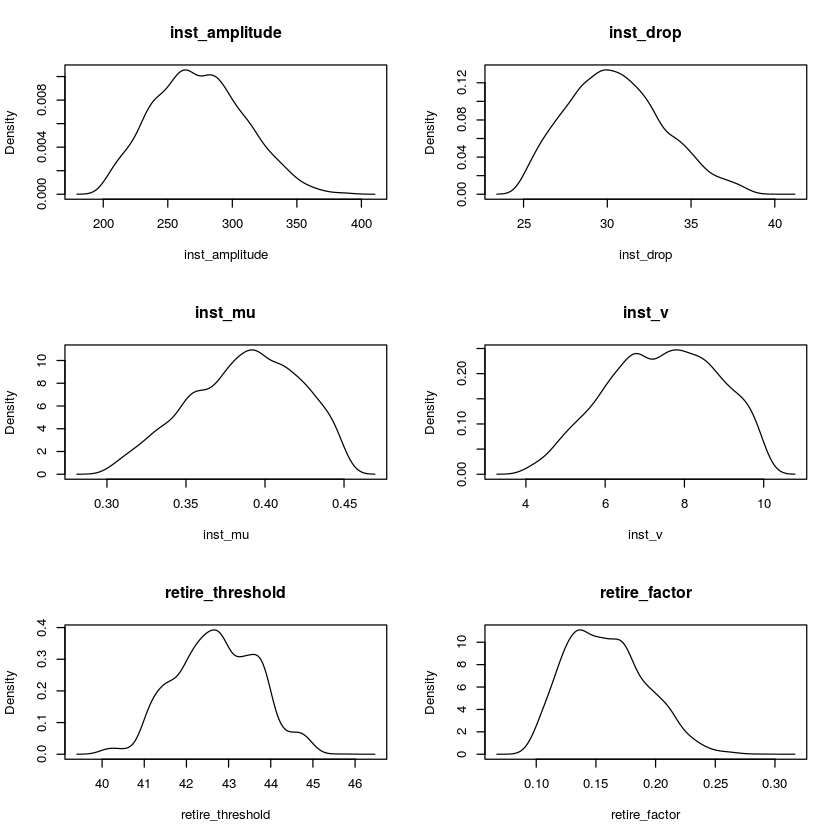

In [14]:
paramsNames = c("inst_amplitude","inst_drop","inst_mu","inst_v","retire_threshold","retire_factor")
par(mfrow=c(3,2))
for (c in 1:ncol(ABC_Lenormand$param)) { 
plot(density(ABC_Lenormand$param[,c],weights = ABC_Lenormand$weights),xlab=paramsNames[c],main=paramsNames[c])
}

In [16]:
write.csv(ABC_Lenormand$param,paste("../out/abc_",nb_simul,"_param.csv",sep=""),row.names=F)
write.csv(ABC_Lenormand$weights,paste("../out/abc_",nb_simul,"_weights.csv",sep=""),row.names=F)

## With 50000 sampling
We perform the same calibration with more sampling.

In [21]:
nb_simul = 50000
p_acc_min=0.4
prior_unif = list(c("unif",200,400), c("unif",25,40), c("unif",0.3,.45), c("unif",4,10), c("unif",40,55), c("unif",0,0.3))
ABC_Lenormand <- ABC_sequential(method="Lenormand", model=simulator, prior=prior_unif, nb_simul=nb_simul, summary_stat_target=ages_target, p_acc_min=p_acc_min,use_seed=TRUE, progress_bar=TRUE)

[1] "    ------ Lenormand et al. (2012)'s algorithm ------"
[1] "step 1 completed"
  |==================================================| 100% Time elapsed: 00:17:58 Estimated time remaining: 00:00:05
[1] "step 2 completed - p_acc = 0.68444"
  |==================================================| 100% Time elapsed: 00:14:10 Estimated time remaining: 00:00:04
[1] "step 3 completed - p_acc = 0.55884"
  |==================================================| 100% Time elapsed: 00:12:56 Estimated time remaining: 00:00:03
[1] "step 4 completed - p_acc = 0.51076"
  |==================================================| 100% Time elapsed: 00:12:15 Estimated time remaining: 00:00:03
[1] "step 5 completed - p_acc = 0.47704"
  |==================================================| 100% Time elapsed: 00:11:36 Estimated time remaining: 00:00:03
[1] "step 6 completed - p_acc = 0.44228"
  |==================================================| 100% Time elapsed: 00:11:01 Estimated time remaining: 00:00:03
[1] 

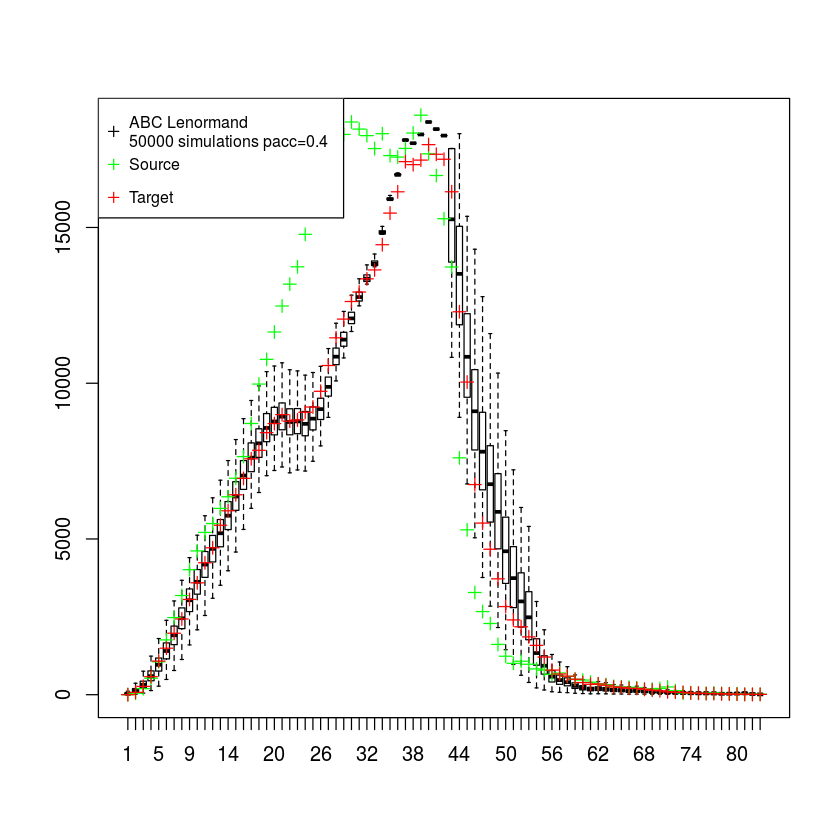

In [22]:
simulated = ABC_Lenormand$stats
boxplot(simulated,outpch=NA)
points(ages_source,pch=3,col="green")
points(ages_target,pch=3,col="red")
legend("topleft", legend=c(paste("ABC Lenormand \n",format(nb_simul)," simulations pacc=",format(p_acc_min),sep=""),"Source","Target"),
       col=c("black","green","red"),cex=.8,pch=3)

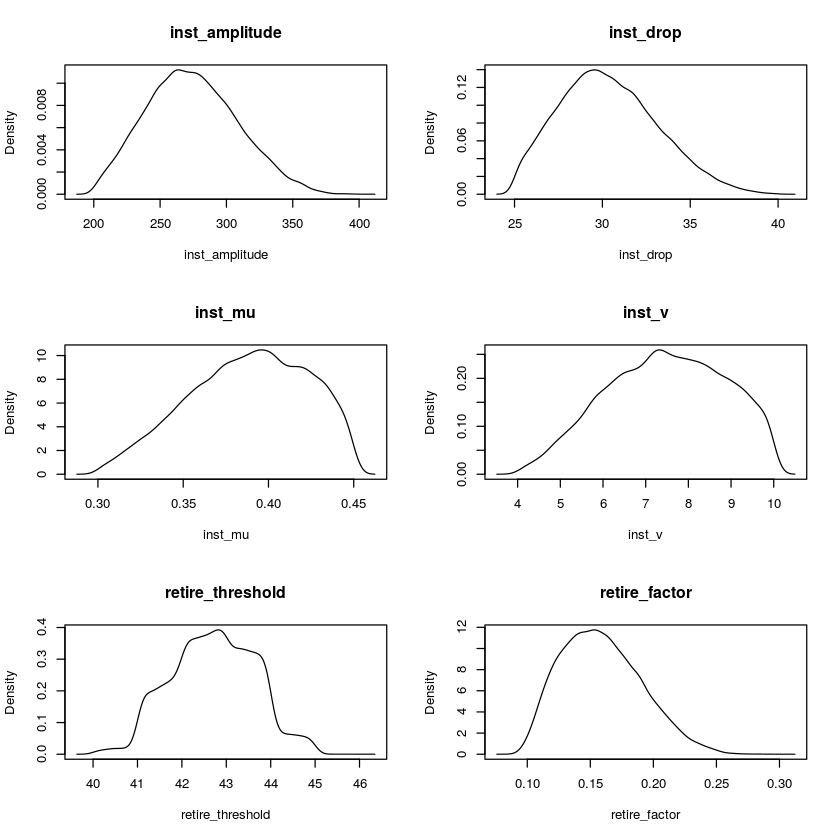

In [23]:
paramsNames = c("inst_amplitude","inst_drop","inst_mu","inst_v","retire_threshold","retire_factor")
par(mfrow=c(3,2))
for (c in 1:ncol(ABC_Lenormand$param)) { 
plot(density(ABC_Lenormand$param[,c],weights = ABC_Lenormand$weights),xlab=paramsNames[c],main=paramsNames[c])
}

In [24]:
write.csv(ABC_Lenormand$param,paste("../out/abc_",nb_simul,"_param.csv",sep=""),row.names=F)
write.csv(ABC_Lenormand$weights,paste("../out/abc_",nb_simul,"_weights.csv",sep=""),row.names=F)